In [103]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import tqdm
import optuna
import warnings
warnings.filterwarnings('ignore')

In [104]:
train_df = pd.read_parquet("train_data.pqt")
test_df = pd.read_parquet("test_data.pqt")

In [105]:
train_df.head()

,id,date,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,...,cnt_cred_g_oper_3m,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,start_cluster,end_cluster
0,0,month_1,0.744845,0.705492,1.287207,0.748101,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.951166,0.568681,0.897565,0.553624,0.774354,0.936506,0.295984,0.967947,"{α, γ}",{other}
1,0,month_2,1.049605,0.831916,2.458609,1.053805,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.948812,0.499716,0.785029,0.551904,0.696576,0.990157,0.298873,0.945969,"{α, γ}",{other}
2,0,month_3,0.692653,0.740253,0.430042,0.695747,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.946458,0.442244,0.877050,0.551044,0.663243,0.810065,0.294829,0.956958,"{α, γ}",{other}
3,1,month_1,-0.081586,-0.091860,-0.114040,-0.080890,channel_code_2,city_14,city_type_0,None,...,0.945281,0.407762,0.369318,0.567093,0.785465,-0.184002,0.253523,0.462452,{other},{other}
4,1,month_2,-0.094962,-0.100504,-0.119302,-0.094307,channel_code_2,city_14,city_type_0,None,...,0.946066,0.430750,0.067275,0.559928,0.696576,-0.183854,0.255545,0.495419,{other},{other}


In [106]:
train_df.shape

(600000, 93)

In [107]:
test_df.head()

,id,date,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,...,sum_cred_g_oper_3m,cnt_cred_g_oper_3m,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,start_cluster
0,200000,month_4,-0.096224,0.335496,-0.125995,-0.095578,channel_code_12,city_14,city_type_0,None,...,0.010952,0.946066,0.407762,-0.153950,0.548895,0.541020,0.031742,0.257278,0.561353,{α}
1,200000,month_5,-0.024255,-0.059806,-0.124295,-0.023381,channel_code_12,city_14,city_type_0,None,...,0.006812,0.945281,0.396267,-0.150505,0.549468,0.552131,0.237817,0.264211,0.715199,{α}
2,200000,month_6,0.045988,0.049418,-0.125995,0.047079,channel_code_12,city_14,city_type_0,None,...,0.006812,0.945281,0.396267,-0.152800,0.549468,0.541020,0.387566,0.268543,0.836079,None
3,200001,month_4,-0.156722,-0.204920,-0.125856,-0.156258,channel_code_9,city_76,city_type_0,None,...,-0.028584,NaN,NaN,-0.165588,NaN,NaN,-0.201123,NaN,NaN,{α}
4,200001,month_5,-0.156722,-0.204920,-0.125856,-0.156258,channel_code_9,city_76,city_type_0,None,...,-0.028584,NaN,NaN,-0.165588,NaN,NaN,-0.201123,NaN,NaN,{α}


In [108]:
test_df.shape

(290120, 92)

Все числовые данные нормализованы

### 1. Количество уникальных значений для категориальных фичей

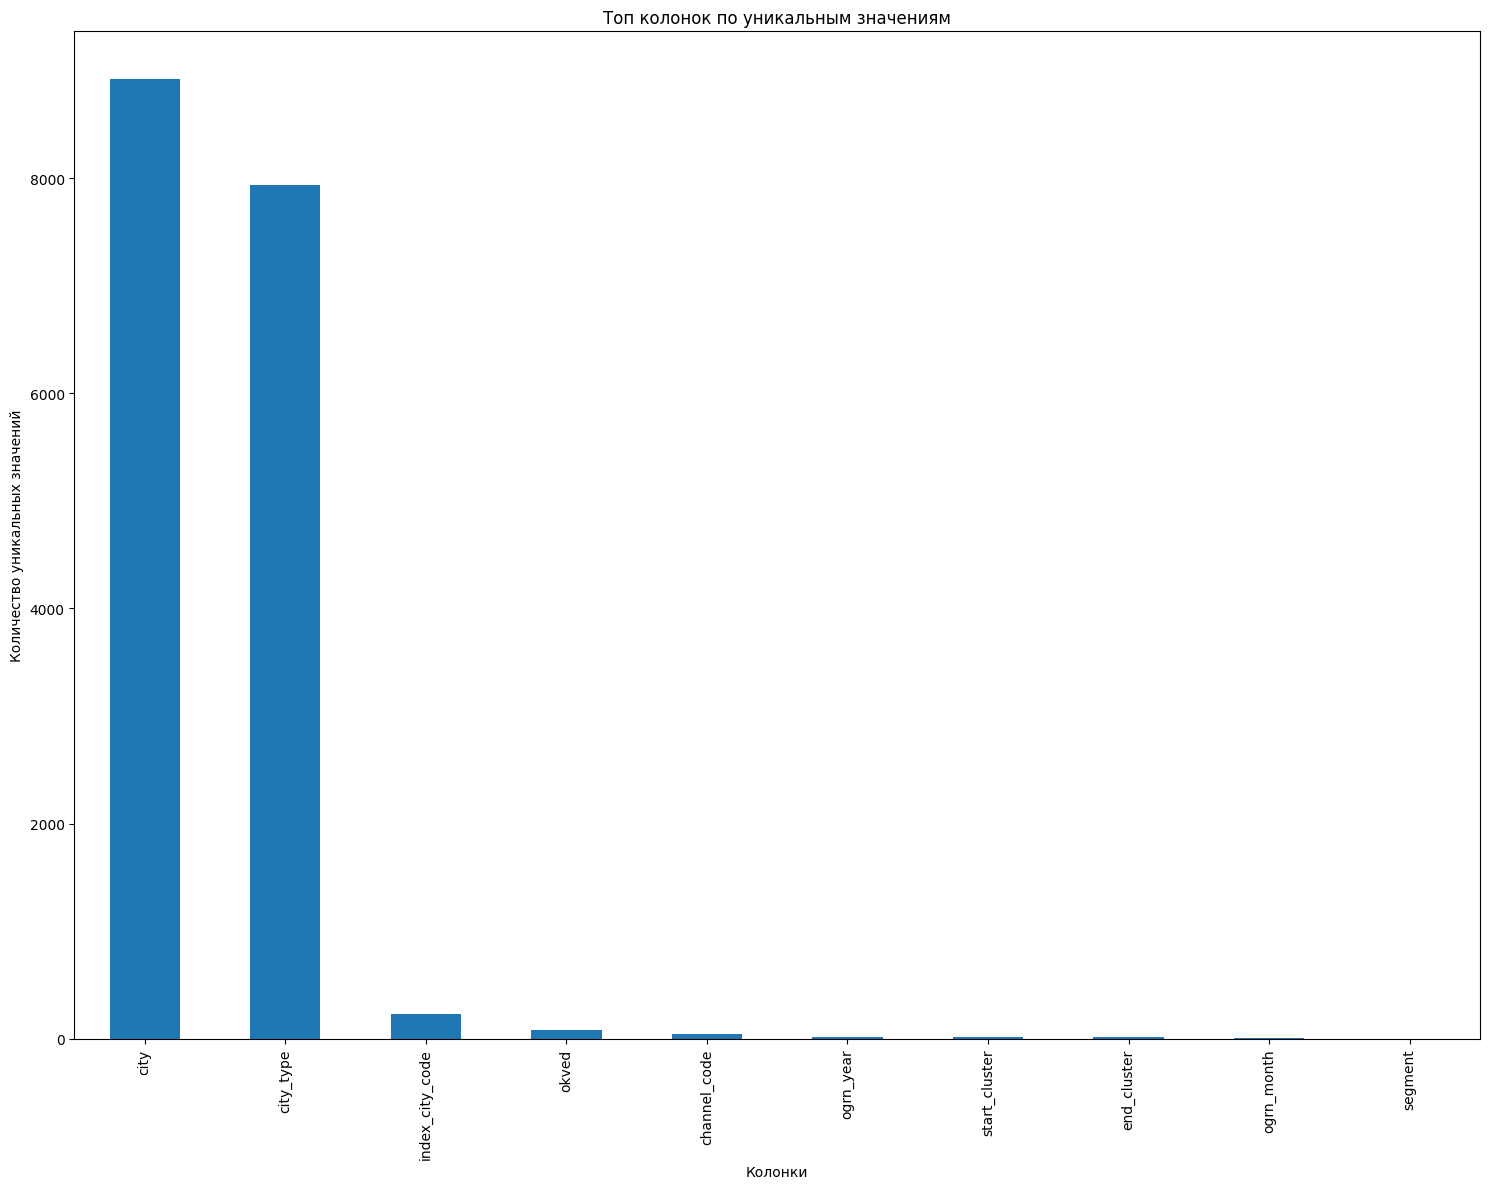

In [109]:
cat_cols = list(np.array(train_df.select_dtypes(exclude="float64").columns))
unique_counts = train_df[cat_cols].drop(['id','date'],axis=1).nunique().sort_values(ascending=False)
top_30_cols = unique_counts.head(len(cat_cols)-2)

plt.figure(figsize=(15,12))
top_30_cols.plot(kind='bar')
plt.ylabel('Количество уникальных значений')
plt.xlabel('Колонки')
plt.title('Топ колонок по уникальным значениям')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### 2. Соотношение классов

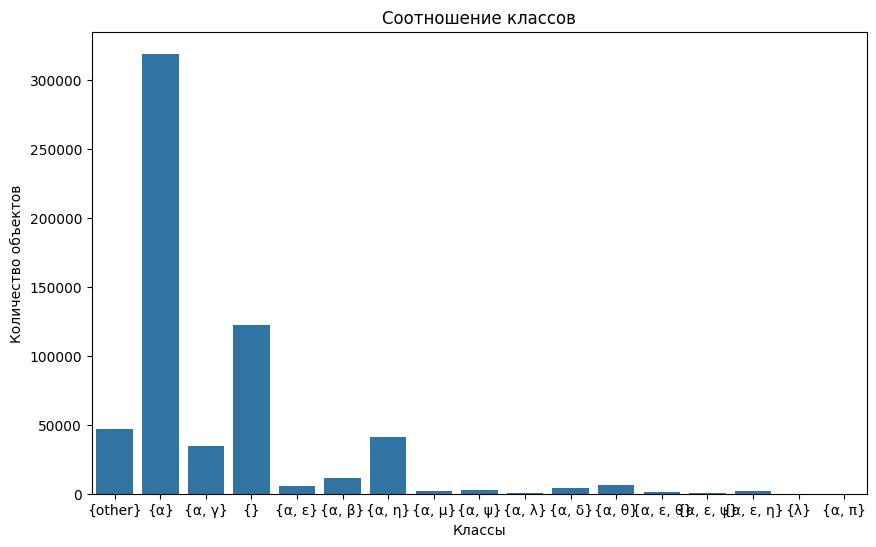

In [110]:
class_counts = train_df['end_cluster'].value_counts()

plt.figure(figsize=(10, 6))
sns.countplot(x='end_cluster', data=train_df)
plt.xlabel('Классы')
plt.ylabel('Количество объектов')
plt.title('Соотношение классов')
plt.show()

### 3. Корреляционная матрица

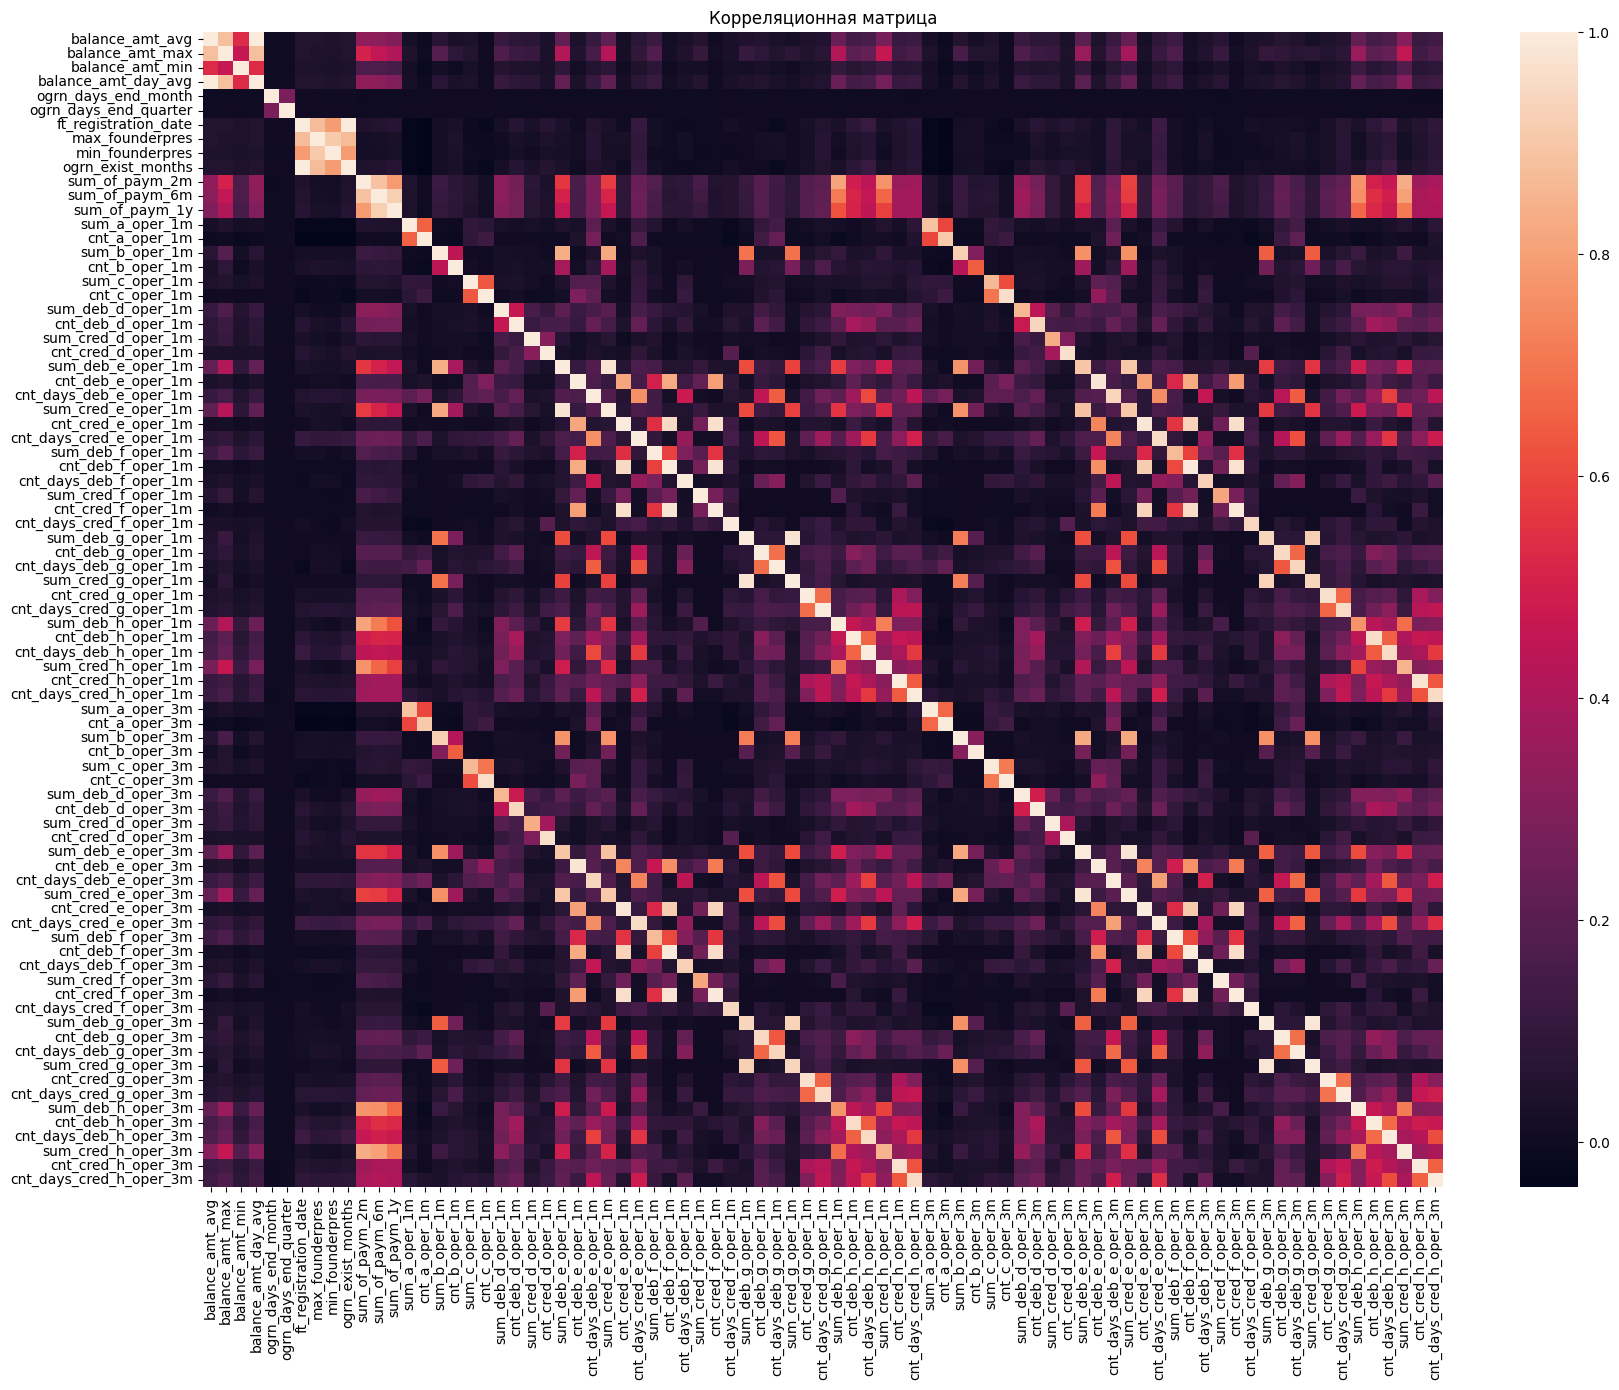

In [111]:
ignore_features = list(np.array(train_df.select_dtypes(exclude="float64").columns))

corr_train_df = train_df.drop(ignore_features, axis=1)
fig, ax = plt.subplots(figsize=(20, 15))
plt.title('Корреляционная матрица')
sns.heatmap(corr_train_df.corr(), fmt='.2g');

### 4. Выявление коррелированных фичей, которые коррелируют друг с другом больше, чем на 0.9

In [112]:
def get_correlated_features(corr_matrix, feat_stats=None, greater_is_better=True, corr_threshold=0.9):
    correlated_features = set()
    
    for col in tqdm.tqdm(corr_matrix.columns, desc='Выявление коррелированных фичей'):
        if col in correlated_features:
            continue
            
        correlated_cols = corr_matrix.index[np.abs(corr_matrix[col]) >= corr_threshold].tolist()
        
        if len(correlated_cols) > 1:
            print(f'{col} -> {correlated_cols}')
            correlated_features.update(correlated_cols[1:])
    
    return list(correlated_features)

In [113]:
clean_df = train_df.copy()
nan_percentage = (clean_df == 0).mean()

clean_df = clean_df.drop(ignore_features, axis=1)

corr_mx = pd.DataFrame(np.corrcoef(clean_df.values, rowvar=False),
                       columns=clean_df.columns,
                       index=clean_df.columns)

corr_features = get_correlated_features(corr_mx, feat_stats=nan_percentage, greater_is_better=False, corr_threshold=0.9)
print('______________________________')
print(f'Коррелированные фичи \n{corr_features}')

Выявление коррелированных фичей: 100%|███████████████████████████████████████████████| 81/81 [00:00<00:00, 5781.70it/s]

sum_b_oper_1m -> ['sum_b_oper_1m', 'sum_b_oper_3m']
sum_deb_e_oper_1m -> ['sum_deb_e_oper_1m', 'sum_cred_e_oper_1m', 'sum_cred_e_oper_3m']
sum_deb_g_oper_1m -> ['sum_deb_g_oper_1m', 'sum_cred_g_oper_1m', 'sum_deb_g_oper_3m', 'sum_cred_g_oper_3m']
sum_deb_e_oper_3m -> ['sum_deb_e_oper_3m', 'sum_cred_e_oper_3m']
______________________________
Коррелированные фичи 
['sum_b_oper_3m', 'sum_deb_g_oper_3m', 'sum_cred_g_oper_3m', 'sum_cred_e_oper_3m', 'sum_cred_e_oper_1m', 'sum_cred_g_oper_1m']


In [114]:
super_clean_df = train_df.copy()
super_clean_df = super_clean_df.drop(corr_features, axis=1)

### 5. Отбор значимых фичей с помощью CatBoost

In [115]:
def get_train_test_split(df, y, test_size=0.2):
    cat_cols = list(np.array(df.select_dtypes(exclude="float64").columns))
    
    if y in cat_cols:
        cat_cols.remove(y)
        
    df[cat_cols] = df[cat_cols].astype("object")  
    df[cat_cols] = df[cat_cols].fillna('NA')
    df[cat_cols] = df[cat_cols].astype("category")
    
    X = df.copy()
    X_train, X_val = train_test_split(X, random_state=42, shuffle=True, test_size=test_size, stratify=X[y])
    
    y_train = pd.Series(X_train[y].values)
    new_X_train = X_train.drop([y], axis=1)

    y_val = pd.Series(X_val[y].values)
    new_X_val = X_val.drop([y], axis=1)
    
    return new_X_train, y_train, new_X_val, y_val, cat_cols


def weighted_roc_auc(y_true, y_pred, labels, weights_dict):
    unnorm_weights = np.array([weights_dict[label] for label in labels])
    weights = unnorm_weights / unnorm_weights.sum()
    classes_roc_auc = roc_auc_score(y_true, y_pred, labels=labels,
                                    multi_class="ovr", average=None)
    return sum(weights * classes_roc_auc)


def feature_importance_func(importance, names, model_name="", top_n=-1, skip_columns=[], plot=False):
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    fi_df = fi_df[~fi_df['feature_names'].isin(skip_columns)]
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    if plot:
        plt.figure(figsize=(12,10))
        sns.barplot(x=fi_df['feature_importance'][:top_n], y=fi_df['feature_names'][:top_n])
        if top_n != -1:
            plt.title(f"{model_name} Feature Importance (Top: {top_n})")
        else:
            plt.title(f"{model_name} Feature Importance")
        plt.xlabel('Feature Importance')
        plt.ylabel('Feature Names')
    
    lst_ = list(fi_df['feature_names'][:top_n])
    return lst_

In [116]:
cluster_weights = pd.read_excel("cluster_weights.xlsx").set_index("cluster")
weights_dict = cluster_weights["unnorm_weight"].to_dict()
sorted_classes = ['{other}' ,'{}', '{α, β}', '{α, γ}' ,'{α, δ}' ,'{α, ε, η}', '{α, ε, θ}',
 '{α, ε, ψ}', '{α, ε}' ,'{α, η}' ,'{α, θ}' ,'{α, λ}' ,'{α, μ}', '{α, π}',
 '{α, ψ}','{α}' ,'{λ}']

sorted_weights = [weights_dict[class_] for class_ in sorted_classes]
sorted_weights_dict = dict(zip(sorted_classes, sorted_weights))


new_train_df = super_clean_df.copy()
new_train_df = new_train_df.drop(['id','date'], axis=1)

Подбор гиперпараметров для CatBoost на всех фичах

In [ ]:
def objective(trial):
    params = {
        "learning_rate": trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        "l2_leaf_reg": trial.suggest_float('l2_leaf_reg', 3, 8),
        "depth" : trial.suggest_int("depth", 3, 8),
        "min_data_in_leaf": trial.suggest_int('min_data_in_leaf', 1, 10),
        "iterations" : trial.suggest_int("iterations", 1000, 1500, 10),
    }

    opt_df = new_train_df.copy()
    new_X_train, y_train, new_X_val, y_val, cat_cols = get_train_test_split(opt_df, 'end_cluster')
    
    catboost_model = CatBoostClassifier(
        loss_function = 'MultiClass',
        random_state = 42,
        task_type = 'GPU',
        use_best_model = True,
        verbose = False,
        cat_features=cat_cols,
        **params
    )
    

    catboost_model.fit(
        new_X_train, y_train,
        eval_set=(new_X_val, y_val),
        plot=False,
        verbose=1000
                )
    
    y_pred_proba = catboost_model.predict_proba(new_X_val)
    
    W_roc_auc = weighted_roc_auc(y_val, y_pred_proba, catboost_model.classes_, sorted_weights_dict)

    return W_roc_auc

study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps = 3), direction = "maximize")
study.optimize(objective, n_trials = 100, timeout = 1800)

best_params = study.best_params

print("Best params:", best_params)

In [118]:
best_params = {'learning_rate': 0.09849595764196017,
               'l2_leaf_reg': 3.1460991581890445,
               'depth': 7,
               'min_data_in_leaf': 5,
               'iterations': 1340}

In [119]:
new_X_train, y_train, new_X_val, y_val, cat_cols = get_train_test_split(new_train_df, 'end_cluster')

CatBoostModel = CatBoostClassifier(
        loss_function = 'MultiClass',
        random_state = 42,
        task_type = 'GPU',
        verbose = False,
        **best_params
    )

CatBoostModel.fit(
    new_X_train, y_train,
    eval_set=(new_X_val, y_val),
    cat_features=cat_cols,
    plot=False,
    verbose=1000
            )

0:	learn: 2.0656694	test: 2.0663971	best: 2.0663971 (0)	total: 362ms	remaining: 8m 5s
1000:	learn: 0.7182674	test: 0.7810561	best: 0.7810561 (1000)	total: 1m 8s	remaining: 23.4s
1339:	learn: 0.6880515	test: 0.7686802	best: 0.7686802 (1339)	total: 1m 32s	remaining: 0us
bestTest = 0.7686802083
bestIteration = 1339


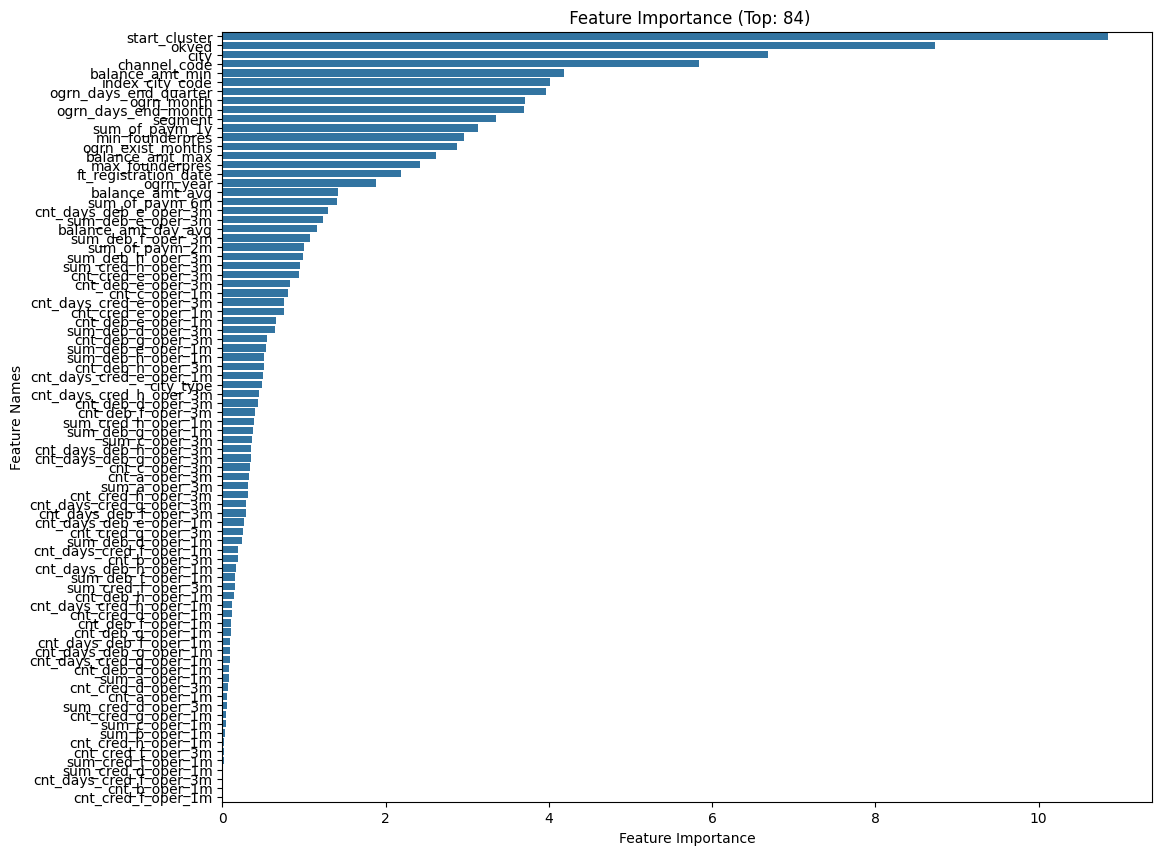

In [120]:
feat_imp = feature_importance_func(CatBoostModel.get_feature_importance(), new_X_val.columns, top_n=new_X_val.shape[1], plot=True)

Цикл для поиска оптимального количества фичей

In [ ]:
list_n_features = []
list_w_roc_auc = []

for n_cols in range(48, 70):
    features = feat_imp[:n_cols] + ['end_cluster']
    new_X_train, y_train, new_X_val, y_val, cat_cols = get_train_test_split(new_train_df[features], 'end_cluster')
    
    CatBoostModel.fit(
        new_X_train, y_train,
        eval_set=(new_X_val, y_val),
        cat_features=cat_cols,
        verbose=False
            )
    
    y_pred_proba = CatBoostModel.predict_proba(new_X_val)
    W_roc_auc = weighted_roc_auc(y_val, y_pred_proba, CatBoostModel.classes_, sorted_weights_dict)
    
    print(f'Кол-во фичей = {n_cols}, weighted_rod_auc = {W_roc_auc}')
    list_n_features.append(n_cols)
    list_w_roc_auc.append(W_roc_auc)

In [123]:
best_n_cols = list_n_features[list_w_roc_auc.index(max(list_w_roc_auc))]
best_w_roc_auc = max(list_w_roc_auc)
print(f'Количество фичей {best_n_cols}, лучший weighted_roc_auc {best_w_roc_auc}')

Количество фичей 35, лучший weighted_roc_auc 0.94544008625941


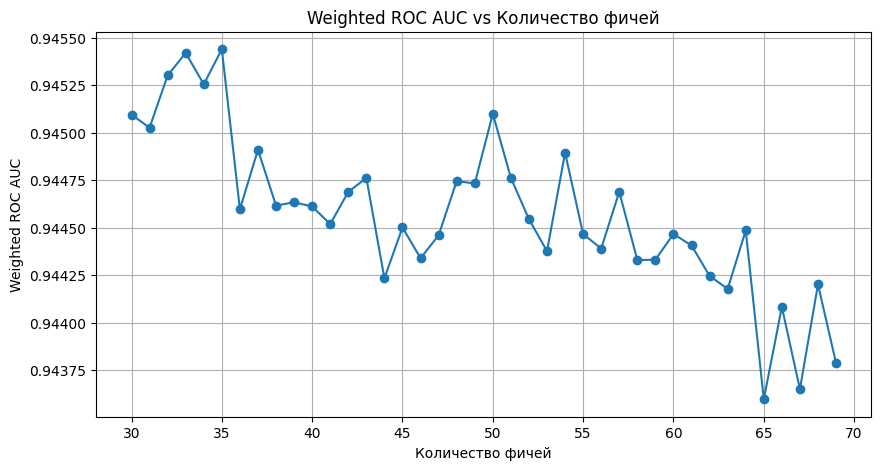

In [124]:
plt.figure(figsize=(10,5))
plt.plot(list_n_features, list_w_roc_auc, marker='o', linestyle='-')

plt.title('Weighted ROC AUC vs Количество фичей')
plt.xlabel('Количество фичей')
plt.ylabel('Weighted ROC AUC')

plt.grid()
plt.show()

Лучший Weighted ROC AUC у модели с 35 фичами, но для стабильности модели и меньшей вероятности переобучения возьмем 50 фичей

In [146]:
best_features = ['start_cluster', 'okved', 'city', 'channel_code', 'balance_amt_min', 'index_city_code', 'ogrn_days_end_quarter',
 'ogrn_month', 'ogrn_days_end_month', 'segment', 'sum_of_paym_1y', 'min_founderpres', 'ogrn_exist_months',
 'balance_amt_max', 'max_founderpres', 'ft_registration_date', 'ogrn_year', 'balance_amt_avg', 'sum_of_paym_6m',
 'cnt_days_deb_e_oper_3m', 'sum_deb_e_oper_3m', 'balance_amt_day_avg', 'sum_deb_f_oper_3m', 'sum_of_paym_2m',
 'sum_deb_h_oper_3m', 'sum_cred_h_oper_3m', 'cnt_cred_e_oper_3m', 'cnt_deb_e_oper_3m', 'cnt_days_cred_e_oper_3m',
 'cnt_cred_e_oper_1m', 'cnt_deb_e_oper_1m', 'sum_deb_d_oper_3m', 'cnt_deb_g_oper_3m', 'cnt_days_cred_e_oper_1m',
 'sum_deb_e_oper_1m', 'sum_deb_h_oper_1m', 'cnt_deb_h_oper_3m', 'city_type', 'cnt_deb_d_oper_3m',
 'cnt_days_cred_h_oper_3m', 'cnt_c_oper_1m', 'cnt_a_oper_3m', 'sum_cred_h_oper_1m', 'cnt_days_cred_g_oper_3m',
 'cnt_deb_f_oper_3m', 'cnt_days_deb_h_oper_3m', 'cnt_c_oper_3m', 'sum_a_oper_3m', 'cnt_b_oper_1m', 'sum_deb_g_oper_3m']